In [11]:
from preprocessing import DataLoader
import os
import pandas as pd

base_path = os.path.dirname(os.getcwd()) 
loader = DataLoader(base_path)
loader.load_all_data()

In [12]:
# Expressions-Daten
exprs_data = loader.exprs_data

# Originale pData
pdata_original = loader.pdata_original

# Imputierte pData
pdata_imputed = loader.pdata_imputed

# All Genes Daten
all_genes_data = loader.all_genes_data

# Common Genes Daten
common_genes_data = loader.common_genes_data

# Intersection Daten
intersection_data = loader.intersection_data

# Merged originale pData
merged_pdata_original = loader.merged_pdata_original

# Merged imputierte pData
merged_pdata_imputed = loader.merged_pdata_imputed

In [26]:
common_genes_data['common_genes_knn_imputed.csv'].isnull().values.any()

False

In [13]:
from preprocessing import DataLoader
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import xgboost as xgb

In [14]:
# 1. Gradient Boosting Survival Analysis

def fit_boosted_survival(X, y):
    # Basic implementation
    model = GradientBoostingSurvivalAnalysis(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        validation_fraction=0.2,  
        n_iter_no_change=10,     
        tol=1e-4                 
    )
    gbsa.fit(X, y)
    return gbsa

# 2. Custom Component-Wise Gradient Boosting
class ComponentWiseGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.base_learners = []
        
    def _compute_negative_gradient(self, y_true, y_pred):
        # Compute negative gradient for Cox partial likelihood
        risk_set = np.zeros(len(y_true))
        for i in range(len(y_true)):
            risk_set[i] = np.sum(np.exp(y_pred[y_true['time'] >= y_true['time'][i]]))
        return y_true['status'] - risk_set * np.exp(y_pred)
    
    def fit(self, X, y):
        current_prediction = np.zeros(len(y))
        
        for _ in range(self.n_estimators):
            # Compute negative gradient
            negative_gradient = self._compute_negative_gradient(y, current_prediction)
            
            # Fit base learner to negative gradient
            base_learner = DecisionTreeRegressor(max_depth=2)
            base_learner.fit(X, negative_gradient)
            
            # Update prediction
            current_prediction += self.learning_rate * base_learner.predict(X)
            self.base_learners.append(base_learner)

# 3. XGBoost for Survival

def create_xgboost_survival(X, y):
    # Convert survival data to XGBoost format
    dtrain = xgb.DMatrix(X)
    dtrain.set_float_info('label', y['time'])
    dtrain.set_float_info('weight', y['status'])
    
    params = {
        'objective': 'survival:cox',
        'eval_metric': 'cox-nloglik',
        'eta': 0.1,
        'max_depth': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        early_stopping_rounds=10
    )
    return model

# 4. Combining Multiple Boosting Models
class EnsembleBoostedSurvival:
    def __init__(self):
        self.models = {
            'gbsa': GradientBoostingSurvivalAnalysis(),
            'component_wise': ComponentWiseGradientBoosting(),
            'xgboost': None  # Will be initialized during fitting
        }
        self.weights = None
    
    def fit(self, X, y):
        predictions = {}
        
        # Fit individual models
        self.models['gbsa'].fit(X, y)
        self.models['component_wise'].fit(X, y)
        self.models['xgboost'] = create_xgboost_survival(X, y)
        
        # Get predictions from each model
        for name, model in self.models.items():
            predictions[name] = model.predict(X)
        
        # Optimize weights using validation set
        self.weights = self._optimize_weights(predictions, y)
    
    def predict(self, X):
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(X)
        
        # Weighted combination
        final_prediction = sum(w * predictions[m] 
                             for m, w in self.weights.items())
        return final_prediction

In [ ]:
import numpy as np
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pandas as pd

class BoostingSurvivalComparison:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {
            'GradientBoosting': self._create_gradient_boosting(),
            'ComponentwiseGradientBoosting': self._create_componentwise_boosting(),
            'XGBoostSurvival': self._create_xgboost()
        }
        self.results = {}
        
    def _create_gradient_boosting(self):
        return GradientBoostingSurvivalAnalysis(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            loss='coxph',
            random_state=self.random_state
        )
    
    def _create_componentwise_boosting(self):
        return ComponentwiseGradientBoostingSurvivalAnalysis(
            n_estimators=100,
            learning_rate=0.1,
            random_state=self.random_state
        )
    
    def _create_xgboost(self):
        return None  # Will be handled separately due to different interface
    
    def _prepare_data(self, X, y):
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled
    
    def evaluate_models(self, X, y, n_splits=5):
        """
        Evaluate all models using k-fold cross-validation
        
        Parameters:
        X: gene expression data (numpy array or pandas DataFrame)
        y: structured survival data with 'status' and 'time'
        n_splits: number of cross-validation folds
        """
        X = self._prepare_data(X, y)
        
        # Initialize results storage
        self.results = {model_name: {'c_index': []} for model_name in self.models.keys()}
        
        # Create cross-validation splits
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            print(f"\nFold {fold + 1}/{n_splits}")
            
            for model_name, model in self.models.items():
                print(f"\nTraining {model_name}...")
                
                if model_name == 'XGBoostSurvival':
                    c_index = self._fit_and_evaluate_xgboost(X_train, X_test, y_train, y_test)
                else:
                    c_index = self._fit_and_evaluate_model(model, X_train, X_test, y_train, y_test)
                
                self.results[model_name]['c_index'].append(c_index)
                print(f"{model_name} C-index for fold {fold + 1}: {c_index:.4f}")
        
        self._summarize_results()
        return self.results
    
    def _fit_and_evaluate_model(self, model, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        pred_risk = model.predict(X_test)
        return concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    def _fit_and_evaluate_xgboost(self, X_train, X_test, y_train, y_test):
        # Convert survival data to XGBoost format
        dtrain = xgb.DMatrix(X_train)
        dtrain.set_float_info('label', y_train['time'])
        dtrain.set_float_info('weight', y_train['status'])
        
        dtest = xgb.DMatrix(X_test)
        
        params = {
            'objective': 'survival:cox',
            'eval_metric': 'cox-nloglik',
            'eta': 0.1,
            'max_depth': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100
        )
        
        pred_risk = model.predict(dtest)
        return concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    def _summarize_results(self):
        print("\nSummary of Results:")
        print("-" * 50)
        for model_name, results in self.results.items():
            c_indices = results['c_index']
            mean_c_index = np.mean(c_indices)
            std_c_index = np.std(c_indices)
            print(f"\n{model_name}:")
            print(f"Mean C-index: {mean_c_index:.4f} (±{std_c_index:.4f})")
            print(f"Min C-index: {min(c_indices):.4f}")
            print(f"Max C-index: {max(c_indices):.4f}")

# Usage example with your data:
def run_boosting_comparison(exprs_data, survival_data):
    # Ensure your survival data is in the correct format
    y = np.array([(status, time) for status, time in 
                  zip(survival_data['BCR_STATUS'], survival_data['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Initialize comparison
    comparison = BoostingSurvivalComparison()
    
    # Run comparison
    results = comparison.evaluate_models(exprs_data, y, n_splits=5)
    
    return comparison, results

# Run the comparison with your data:
exprs = loader.intersection_data['exprs_intersect.csv']
survival_data = loader.merged_pdata_imputed['merged_imputed_pData.csv']

comparison, results = run_boosting_comparison(exprs, survival_data)




Fold 1/5

Training GradientBoosting...


c-score:0.7146
 6934 mit merged data ,676 mit intersection data
 



C-index with clinical features: 0.6760

Top 10 most important features:
                feature  importance
13224  PATH_T_STAGE_T3B    0.178864
10519   ENSG00000175063    0.166589
1481    ENSG00000088325    0.103817
7099    ENSG00000147655    0.086229
10101   ENSG00000171703    0.066007
5356    ENSG00000133265    0.051063
1716    ENSG00000096088    0.050844
1229    ENSG00000079393    0.039888
5338    ENSG00000133110    0.026058
226     ENSG00000010818    0.018873


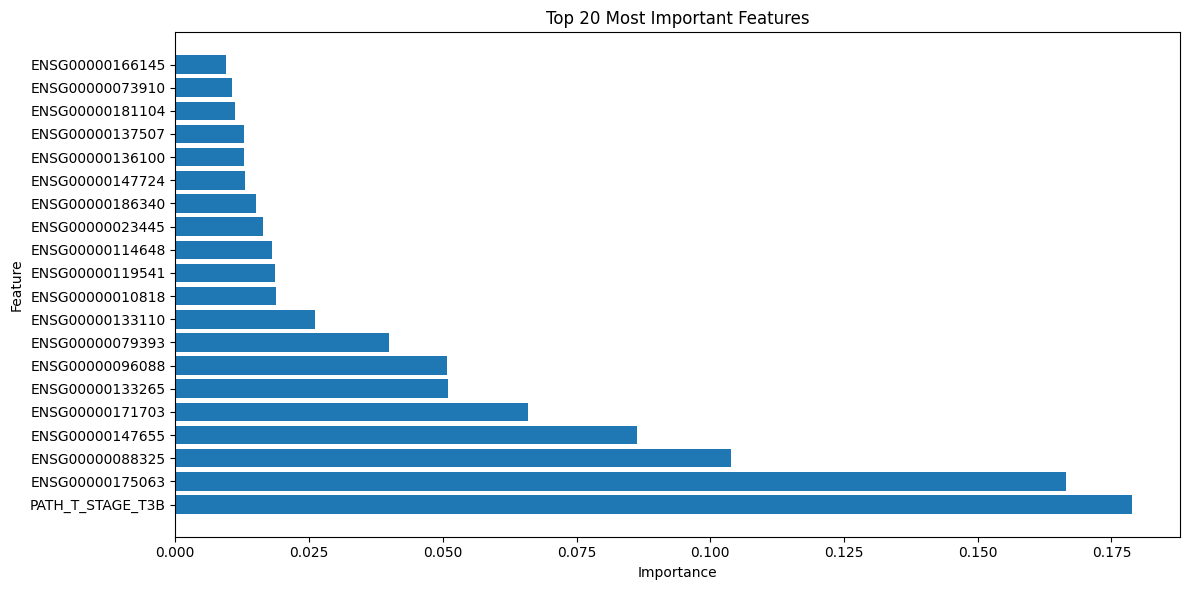

In [28]:
def prepare_clinical_features(pdata):
    """
    Prepare clinical features from pData
    """
    # Select relevant clinical features
    clinical_features = ['GLEASON_SCORE', 'PATH_T_STAGE', 'CLIN_T_STAGE', 'PRE_OPERATIVE_PSA']
    
    # Create copy to avoid modifying original data
    clinical_data = pdata[clinical_features].copy()
    
    # Convert categorical variables to dummy variables
    categorical_features = ['PATH_T_STAGE', 'CLIN_T_STAGE']
    clinical_data = pd.get_dummies(
        clinical_data, 
        columns=categorical_features, 
        drop_first=True,
        prefix=categorical_features
    )
    
    # Handle missing values in numerical columns
    numerical_columns = ['GLEASON_SCORE', 'PRE_OPERATIVE_PSA']
    clinical_data[numerical_columns] = clinical_data[numerical_columns].fillna(
        clinical_data[numerical_columns].median()
    )
    
    return clinical_data

def run_boosting_comparison_with_clinical(exprs_data, pdata, survival_data):
    """
    Run gradient boosting with both genetic and clinical data
    """
    # Prepare clinical features
    clinical_data = prepare_clinical_features(pdata)
    
    # Combine genetic and clinical data
    combined_features = pd.concat([
        exprs_data,
        clinical_data
    ], axis=1)
    
    # Create survival array
    y = np.array([(status, time) for status, time in 
                  zip(survival_data['BCR_STATUS'], survival_data['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Create and run gradient boosting model
    model = GradientBoostingSurvivalAnalysis(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        validation_fraction=0.2,  
        n_iter_no_change=10,     
        tol=1e-4                 
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, y, test_size=0.2, random_state=42
    )
    
    # Fit model
    gb_model.fit(X_train, y_train)
    
    # Get predictions
    pred_risk = gb_model.predict(X_test)
    c_index = concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': combined_features.columns,
        'importance': gb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return gb_model, c_index, feature_importance

# Run the comparison
exprs = loader.intersection_data['exprs_intersect.csv']
pdata = loader.merged_pdata_imputed['merged_imputed_pData.csv']
survival_data = loader.merged_pdata_imputed['merged_imputed_pData.csv']

model, c_index, feature_importance = run_boosting_comparison_with_clinical(
    exprs, pdata, survival_data
)

print(f"\nC-index with clinical features: {c_index:.4f}")
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Optional: Visualize feature importance
import matplotlib.pyplot as plt

def plot_feature_importance(feature_importance, top_n=20):
    plt.figure(figsize=(12, 6))
    top_features = feature_importance.head(top_n)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance)